In [ ]:
from google.colab import drive
drive.mount('/content/drive/')
import pandas as pd
import os
from pandas.core.common import SettingWithCopyWarning
import warnings
import time
import re, copy, pickle
start_time=time.time()
pd.set_option('display.float_format', lambda x: '%.2f' % x)
warnings.simplefilter(action="ignore", category=SettingWithCopyWarning)

files=['df_data_2021','df_data_2015-2021','df_data_2010-2015','df_data_2003-2010']
#files=['df_data_2021']

Mounted at /content/drive/


In [ ]:
def default_filter(df):
  #default setting: age>=16, work full time, some specific occupation are excluded.
  df['PWORWGT']=df['PWORWGT'].div(10000)
  df['PTERNWA']=df['PTERNWA'].div(100)
  df=df.loc[df['PTERNWA']>=24.5]
  df=df.loc[(df['HRINTSTA']==1) & (df['PRTAGE']>=16) & (df['PRPERTYP']==2) & \
((df['HRMIS']==4) | (df['HRMIS']==8)) & ((df['PEMLR']>=1) & (df['PEMLR']<=2)) & \
((df['PEHRUSL1']>=35) | ((df['PEMJOT']==2)&(df['PEHRFTPT']==1))) & \
(((df['PRDTCOW1']>=1)&(df['PRDTCOW1']<=2))|((df['PRDTCOW1']>=5)&(df['PRDTCOW1']<=9))) & (df['PEIO1COW'] != 6)] 
  df_income_all=df[['CPSDATE','ID','PWORWGT','PTERNWA','PRTAGE','PESEX','PTDTRACE','PEEDUCA', 'PRDTOCC1']]
  return df_income_all



In [ ]:
#Additional Filter: age-PRTAGE, sex-PESEX, race-PTDTRACE, education-PEEDUCA, occupation-PRDTOCC1. 'all' means to use the default setting.
#addtional_filter=[[‘all’,’all’,’all’,’all’,’all’], [‘all,’men’,’all’,’all’,’all’], [‘all’,’women’,’all’,’all’,’all’], [‘all’,’all’,’all’,’bachelor and above’,’all’], [’between 25 and 54’,’all’,’white only’,’all’,’all’] , [‘all,’all’,’asian only’,’all’,’all’],[’between 25 and 54’,’all’,’asian only’,’all’,’all’],[‘all’,’all’,’all’,’all’,’ Management, business, and financial operations occupations’]]
operatorsRep = {'>=':'ge','<=':'le','<':'lt','>':'gt','!=':'ne','=':'eq'}
filter_dic={'between 25 and 54':'between 25 and 54', '>=25':'>=25',\
            'men':'=1', 'women':'=2', 'bachelor and above': '>=43', 'white only': '=1', 'asian only': '=4',\
            'Management, business, and financial operations occupations': 'between 1 and 2'}

additional_filters=[{'age-PRTAGE':'all', 'sex-PESEX': 'all', 'race-PTDTRACE': 'all', 'education-PEEDUCA': 'all', 'occupation-PRDTOCC1': 'all'},\
                   {'age-PRTAGE':'all', 'sex-PESEX': 'men', 'race-PTDTRACE': 'all', 'education-PEEDUCA': 'all', 'occupation-PRDTOCC1': 'all'},\
                   {'age-PRTAGE':'all', 'sex-PESEX': 'women', 'race-PTDTRACE': 'all', 'education-PEEDUCA': 'all', 'occupation-PRDTOCC1': 'all'},\
                    {'age-PRTAGE':'>=25', 'sex-PESEX': 'all', 'race-PTDTRACE': 'all', 'education-PEEDUCA': 'bachelor and above', 'occupation-PRDTOCC1': 'all'},\
                   {'age-PRTAGE':'between 25 and 54', 'sex-PESEX': 'all', 'race-PTDTRACE': 'white only', 'education-PEEDUCA': 'all', 'occupation-PRDTOCC1': 'all'},\
                   {'age-PRTAGE':'all', 'sex-PESEX': 'all', 'race-PTDTRACE': 'asian only', 'education-PEEDUCA': 'all', 'occupation-PRDTOCC1': 'all'},\
                    {'age-PRTAGE':'all', 'sex-PESEX': 'all', 'race-PTDTRACE': 'all', 'education-PEEDUCA': 'all', 'occupation-PRDTOCC1': 'Management, business, and financial operations occupations'},\
                   {'age-PRTAGE':'between 25 and 54', 'sex-PESEX': 'all', 'race-PTDTRACE': 'asian only', 'education-PEEDUCA': 'all', 'occupation-PRDTOCC1': 'all'}
                   ]

In [ ]:
def additional_filter(df_income, filter):
  for k, v in filter.items():
    if v!='all':
      col_name=re.findall('.+-(\w+)', k)[0]
      match=re.findall('between (\d+) and (\d+)', filter_dic[v])
      if not match:
        condition=re.findall('(.*\D)(\d+)',filter_dic[v])
        operator=operatorsRep[condition[0][0]]
        filter_value=int(condition[0][1])
        if operator in ('ne', 'lt', 'le', 'gt', 'ge'):
            df_income = df_income.loc[getattr(df_income[col_name], operator)(filter_value)]
        elif operator == 'eq':
            df_income = df_income.loc[df_income[col_name]==filter_value]
      else:
        df_income=df_income.loc[(df_income[col_name]>=int(match[0][0])) & (df_income[col_name]<=int(match[0][1]))]
  return df_income


In [ ]:

path='/content/drive/My Drive/BOC_V6/all_data/'
folders=os.listdir(path)
dataList=[]
for sub_fileName in files:
  df=pd.DataFrame()
  for folder in folders:
    fileName=sub_fileName+'_'+str(folder)
    path_file=path+folder+'/'+fileName+'.csv'
    df_sub=pd.read_csv(path_file)
    if folder=='V1':
      df=df_sub
    else:
      if folder=='V2':
        df_sub=df_sub.drop(columns=["CPSDATE", "PRTAGE", "PWCMPWGT"])
      elif folder=='V3':
        df_sub=df_sub.drop(columns=["CPSDATE", "PRTAGE", "PWCMPWGT"])
      elif folder=='V4':
        df_sub=df_sub.drop(columns=["CPSDATE", "PWCMPWGT"])
      df=df.merge(df_sub, how='left', on='ID')
  df_income_all=default_filter(df)
  unique_cpsdates=df_income_all['CPSDATE'].unique()
  for cpsdate in unique_cpsdates:
    df_income0=df_income_all.loc[df_income_all['CPSDATE']==cpsdate]
    num_filter=0
    for filter in additional_filters:
      num_filter+=1
      df_income=additional_filter(df_income0, filter)
      weight_median_point=df_income['PWORWGT'].sum()*0.5
      df_income.sort_values(by=['PTERNWA'],inplace=True)
      df_income.reset_index(drop=True, inplace=True)
      weight_sum=0
      for index, row in df_income.iterrows():
        weight_sum = weight_sum + row['PWORWGT']
        if weight_sum >= weight_median_point:
          bin_median=((row['PTERNWA']/100+31.755)-32)//0.5
          index_end=index
          break

      size=len(df_income)
      std=df_income['PTERNWA'].std()

      df_additional_weight=df_income.loc[(df_income.index<=index_end) & (((df_income['PTERNWA']/100+31.755)-32)//0.5==bin_median)]
      additional_weight=df_additional_weight['PWORWGT'].sum()
      weight_sum_up_to_median_bin=weight_sum-additional_weight
      df_weight_bin_median=df_income.loc[(((df_income['PTERNWA']/100+31.755)-32)//0.5==bin_median)]
      weight_bin_median=df_weight_bin_median['PWORWGT'].sum()
      transformed_median_income=(32+bin_median*0.5)+0.5*(weight_median_point-weight_sum_up_to_median_bin)/weight_bin_median
      median_income=(transformed_median_income-31.755)*100
      filter_conditions=list(filter.values())
      dataList_sub=[cpsdate, median_income, size, std, num_filter]

      dataList_sub.extend(filter_conditions)
      dataList.append(dataList_sub) 


df_result=pd.DataFrame(dataList)
df_result.columns=['Date','Median Wage', 'sample size','std(wage)', 'num_filter','Age(all means over 16yrs)', 'Sex', 'Race', 'Education','Occupation']     
df_result.sort_values(by=['num_filter','Date'], inplace=True)
df_result.reset_index(drop=True, inplace=True)
df_result0=df_result
df_result0.to_csv("/content/drive/My Drive/BOC_V6/cpsResult_resultMonthly2003-2021.csv", index=False)
      
  
df_result0.head(3)


,Date,Median Wage,sample size,std(wage),num_filter,Age(all means over 16yrs),Sex,Race,Education,Occupation
0,2003-01,615.97,12333,500.79,1,all,all,all,all,all
1,2003-02,623.55,12227,505.85,1,all,all,all,all,all
2,2003-03,622.91,12326,500.55,1,all,all,all,all,all


In [ ]:
import re
def year_season(cpsdate):
    match=re.findall('(\d+)-(\d+)', cpsdate)
    cpsyear=match[0][0]
    cpsmonth=int(match[0][1])
    season=None
    if cpsmonth<=3:
        season=1
    elif cpsmonth<=6:
        season=2
    elif cpsmonth<=9:
        season=3
    elif cpsmonth<=12:
        season=4
    return cpsyear+'-'+str(season)

In [ ]:
df_result.insert(1,'year-season',[year_season(str(date)) for date in df_result['Date']])
df_result_quarterly=df_result.groupby(by=['num_filter','Age(all means over 16yrs)', 'Sex', 'Race', 'Education','Occupation','year-season'], as_index=False).mean()
df_result_quarterly.sort_values(by=['num_filter','year-season'], inplace=True)
df_result_quarterly.reset_index(drop=True, inplace=True)
new_cols=['year-season','Median Wage','sample size','std(wage)','num_filter','Age(all means over 16yrs)', 'Sex', 'Race', 'Education','Occupation']
df_result_quarterly= df_result_quarterly.reindex(columns=new_cols)
df_result_quarterly.to_csv("/content/drive/My Drive/BOC_V6/cpsResult_resultQuarterly2003-2021.csv", index=False)
df_result_quarterly

,year-season,Median Wage,sample size,std(wage),num_filter,Age(all means over 16yrs),Sex,Race,Education,Occupation
0,2003-1,620.81,12295.33,502.40,1,all,all,all,all,all
1,2003-2,617.03,12291.33,505.33,1,all,all,all,all,all
2,2003-3,619.30,12195.67,497.95,1,all,all,all,all,all
3,2003-4,627.63,12059.67,507.69,1,all,all,all,all,all
4,2004-1,634.76,12012.67,516.95,1,all,all,all,all,all
...,...,...,...,...,...,...,...,...,...,...
595,2020-3,1517.35,393.00,807.22,8,between 25 and 54,all,asian only,all,all
596,2020-4,1364.54,433.33,798.41,8,between 25 and 54,all,asian only,all,all
597,2021-1,1390.86,438.67,814.44,8,between 25 and 54,all,asian only,all,all
598,2021-2,1364.01,433.00,794.81,8,between 25 and 54,all,asian only,all,all


In [ ]:
#Comparision

df_result_monthly0=pd.read_csv("/content/drive/My Drive/cpsResult_df_resultMonthly2021")
df_result_quarterly0=pd.read_csv("/content/drive/My Drive/cpsResult_df_resultquarterly2021")

different_Monthly=False
for index, row in df_result_monthly0.iterrows():
  df_diff=df_result0.loc[(df_result0['Date']==row['Date']) & (df_result0['Age(all means over 16yrs)']==row['Age(all means over 16yrs)']) & (df_result0['Sex']==row['Sex']) & (df_result0['Race']==row['Race']) & (df_result0['Education']==row['Education']) & (df_result0['Occupation']==row['Occupation'])]
  if round(df_diff['Median Wage'].item(),3) != round(row['Median Wage'],3):
    display(df_diff)
    print('\n')
    different_Monthly=True
if not different_Monthly:
  print('all data are same as saved df_result_monthly')

different_Quarterly=False
for index, row in df_result_quarterly0.iterrows():
  df_diff=df_result_quarterly.loc[(df_result_quarterly['year-season']==row['year-season']) &\
                                  (df_result_quarterly['Age(all means over 16yrs)']==row['Age(all means over 16yrs)']) & \
                                  (df_result_quarterly['Sex']==row['Sex']) & (df_result_quarterly['Race']==row['Race']) & \
                                  (df_result_quarterly['Education']==row['Education']) & (df_result_quarterly['Occupation']==row['Occupation'])]

  if round(df_diff['Median Wage'].item(),3) != round(row['Median Wage'],3):
    display(df_diff)
    print('\n')
    different_Quarterly=True
if not different_Quarterly:
  print('all data are same as saved df_result_quarterly')

all data are same as saved df_result_monthly
all data are same as saved df_result_quarterly


In [ ]:
end_time=time.time()
total_time=round((end_time-start_time)/60,1)
print(f'total running time is {total_time} minutes')

total running time is 9.7 minutes


In [ ]:
from google.colab import drive
drive.mount('/content/drive/')
import pandas as pd
df_result_quarterly0=pd.read_csv("/content/drive/My Drive/BOC_V6/cpsResult_resultQuarterly2003-2021.csv")
df_result_quarterly0=df_result_quarterly0.loc[df_result_quarterly0['num_filter']==1]

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


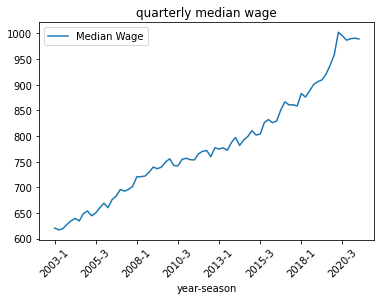

In [ ]:
df_result_quarterly0.plot(title='quarterly median wage', rot=45, x='year-season', y='Median Wage')